#### Libraries and dependencies

In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.signal import butter
from copy import deepcopy
from scipy.signal import filtfilt
from hmmlearn import hmm
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]
print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


In [7]:
probes.head()

,ecephys_session_id,name,sampling_rate,lfp_sampling_rate,phase,has_lfp_data,unit_count,channel_count,structure_acronyms,file_id
ecephys_probe_id,,,,,,,,,,
1044506933,1044385384,probeB,30000.178402,2500.014867,1.0,True,701,384,"['CA1', 'DG', 'LP', 'POL', 'PoT', 'VISpm', 'ro...",0
1044506934,1044385384,probeC,30000.049852,2500.004154,1.0,True,307,384,"['MB', 'MRN', 'POST', 'SCig', 'VISp', 'root']",1
1044506935,1044385384,probeD,30000.029115,2500.002426,1.0,True,521,384,"['CA1', 'CA3', 'DG', 'LGv', 'MB', 'TH', 'VISl'...",2
1044506936,1044385384,probeE,30000.075851,2500.006321,1.0,True,282,384,"['CA1', 'DG', 'MB', 'MGd', 'MGm', 'MRN', 'SGN'...",3
1044506937,1044385384,probeF,29999.959578,2499.996631,1.0,True,368,384,"['CA1', 'DG', 'LP', 'MRN', 'POL', 'PoT', 'SGN'...",4


In [29]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore

probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp

chans = session.get_channels()

In [46]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values
stim_ids = stim.index.values
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
print(start)
print(end)

26.51665497698943
3627.411090114033


In [115]:
master_time = np.arange(start, end, 1/1250)

#### Aligning LFP (not really used here)

In [71]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [72]:
aligned_lfp = align_lfp(probeB_slice, np.arange(-0.2, 0.2, 1/10), stim_times[0:2], stim_ids[0:2])

Text(-0.4, 3570, 'brain surface')

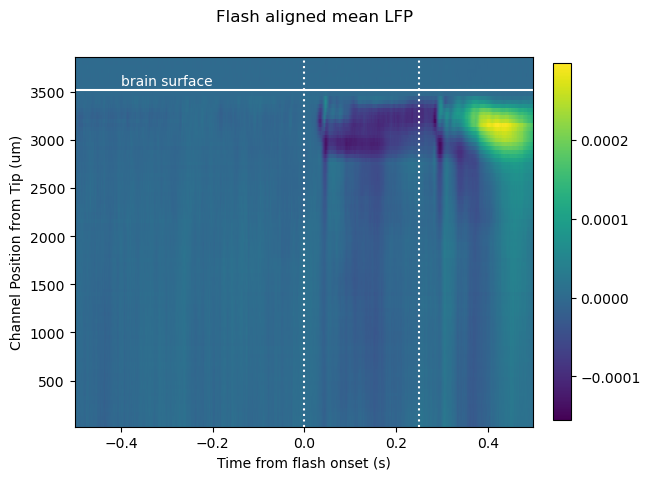

In [27]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

#### Filtering

In [147]:
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
B_single = lfpB_copy.T[48]
C_single = lfpC_copy.T[48]
print(len(B_single))
print(len(C_single))

4501119
4501119


In [149]:
bands = np.zeros((8, len(B_single)))

In [161]:
bands = np.zeros((4, len(B_single)))

In [155]:
from scipy.stats import zscore

In [156]:
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    b,a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba')
    bands[2*i] = zscore(filtfilt(b, a, B_single))
    bands[2*i+1] = zscore(filtfilt(b, a, C_single))

In [162]:
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    b,a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba')
    bands[i] = zscore(filtfilt(b, a, B_single))

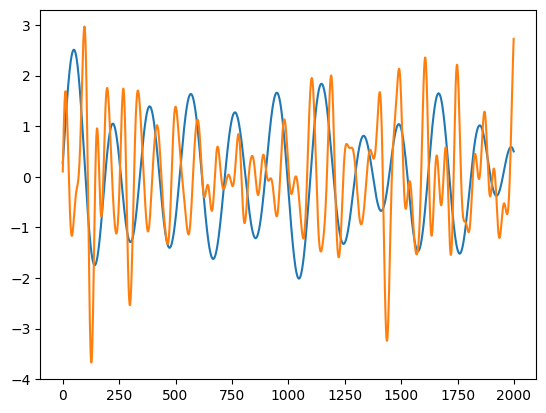

In [163]:
fig, ax = plt.subplots()
ax.plot(bands[0][0:2000])
ax.plot(bands[1][0:2000])

#### Gaussian HMM for LFP here

In [158]:
model = hmm.GaussianHMM(n_components=5, n_iter=100,verbose=True, tol=0.1)
model.fit(bands.T)

         1 -50258630.76724360             +nan
         2 -45676266.73620988 +4582364.03103372
         3 -44216230.58216025 +1460036.15404963
         4 -43761493.13766577 +454737.44449448
         5 -43552909.13201854 +208584.00564723
         6 -43426899.03945626 +126010.09256227
         7 -43332978.45592107  +93920.58353519
         8 -43253854.21108671  +79124.24483436
         9 -43183457.91057435  +70396.30051236
        10 -43100695.48463134  +82762.42594301
        11 -42927112.86626934 +173582.61836199
        12 -42734530.10652843 +192582.75974091
        13 -42630295.49824245 +104234.60828598
        14 -42539259.45831065  +91036.03993180
        15 -42474177.41196892  +65082.04634173
        16 -42431093.80171780  +43083.61025112
        17 -42400450.31449778  +30643.48722002
        18 -42373646.09041078  +26804.22408700
        19 -42345664.33403936  +27981.75637142
        20 -42314446.35216531  +31217.98187405
        21 -42279176.22701444  +35270.12515087
        22 

GaussianHMM(n_components=5, n_iter=100, tol=0.1, verbose=True)

In [159]:
preds= model.predict(bands.T)
print(np.unique(preds))

[0 1 2 3 4]


In [186]:
model1 = hmm.GaussianHMM(n_components=5, n_iter=100, verbose=True, tol=0.1)
model1.fit(bands.T[0:10000])

         1  -55924.78908763             +nan
         2  -49942.62365353   +5982.16543411
         3  -48506.22288001   +1436.40077352
         4  -47957.34659973    +548.87628028
         5  -47415.75908113    +541.58751860
         6  -47065.46327623    +350.29580490
         7  -46858.19695916    +207.26631707
         8  -46511.68624441    +346.51071476
         9  -46077.16599456    +434.52024984
        10  -45623.39571928    +453.77027528
        11  -45259.92682347    +363.46889581
        12  -44966.22500474    +293.70181873
        13  -44794.43919144    +171.78581330
        14  -44682.71083552    +111.72835592
        15  -44639.39987422     +43.31096130
        16  -44621.31163491     +18.08823931
        17  -44609.16818344     +12.14345147
        18  -44600.47643796      +8.69174548
        19  -44592.05745766      +8.41898031
        20  -44582.84636393      +9.21109373
        21  -44576.12888901      +6.71747492
        22  -44570.80458709      +5.32430192
        23

GaussianHMM(n_components=5, n_iter=100, tol=0.1, verbose=True)

In [166]:
preds= model1.predict(bands.T)
print(np.unique(preds))

[0 1 2]


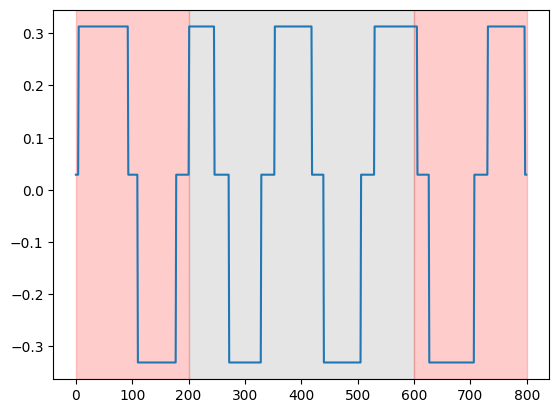

In [185]:
means = model1.means_
vals = np.mean(means[preds], axis=1)
plt.plot(vals[0:800])
plt.axvspan(0,250*0.8, alpha=0.2, color='red')
plt.axvspan(250*0.8, 750*0.8, alpha=0.2, color='gray')
plt.axvspan(750*0.8,1000*0.8, alpha=0.2, color='red')

In [187]:
preds= model1.predict(bands.T)
print(np.unique(preds))

[0 1 2 3 4]


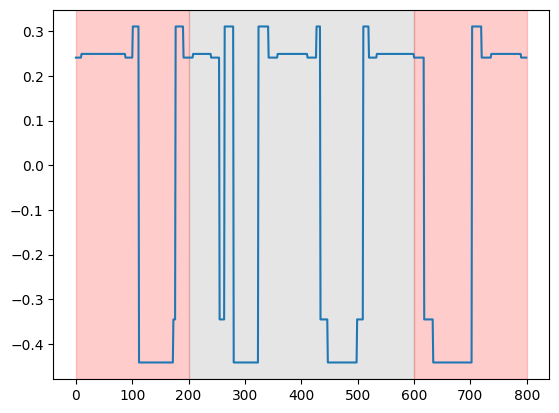

In [190]:
means = model1.means_
vals = np.mean(means[preds], axis=1)
plt.plot(vals[0:800])
plt.axvspan(0,250*0.8, alpha=0.2, color='red')
plt.axvspan(250*0.8, 750*0.8, alpha=0.2, color='gray')
plt.axvspan(750*0.8,1000*0.8, alpha=0.2, color='red')